# Regression ANN with best parameters
    find the best prediction window to apply with a rolling Nested CV technique

In [26]:
import pandas as pd;
import numpy as np;
import sklearn
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict;
from sklearn.preprocessing import MinMaxScaler;
from sklearn import metrics;
from sklearn.model_selection import TimeSeriesSplit;

dates = [2017000000, 2017030000, 2017060000, 2017090000, 2018000000, 2018030000, 2018060000, 2018090000]
dates_labels = ['24 months', 
                '21 months',  
                '18 months', 
                '15 months', 
                '12 months', 
                '9 months',
                '6 months',
                '3 months']

mae_cv = []
mse_cv = []
mae_gen = []
mse_gen  =[]
rmse_gen = []
mae_nor = []
mae_spi = []
mse_nor = []
mse_spi = []
rmse_nor = []
rmse_spi = []

# Loop with model for 8 different data ranges (3 months intervals):

In [27]:
for i in dates:
    count = 0
    # data
    data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)
    data = data.loc[data.index > i, :]
    
    # reset index
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    
    # Divide features and labels
    X = data.iloc[:, 0:15]
    y = data.loc[:, 'Offers']
    
    X.fillna(X.mean(), inplace = True)
    y.fillna(y.mean(), inplace = True)
    
    X = X.astype('float64')
    X = X.round(20)
    
    # divide data into train and test with 20% test data
    X_train, X_test, y_train, y_test = train_test_split(
             X, y, test_size=0.2, shuffle=False)
    
    # feature scaling
    sc_X = MinMaxScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    
    import keras
    from keras.models import Sequential # to initialise the NN
    from keras.layers import Dense # to create layers
    from keras.layers import Dropout
    from keras import initializers
    import keras.optimizers
    from keras.wrappers.scikit_learn import KerasRegressor
    
    # possible debug
    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    
    def regressor_tunning(n_hidden = 2, 
                          n_neurons = 30, 
                          optimizer = 'Adamax', 
                          kernel_initializer = "he_normal",
                          bias_initializer = initializers.Ones()):
        model = Sequential()
        model.add(Dense(units = n_neurons, input_dim = 15))
        model.add(keras.layers.LeakyReLU(alpha = 0.2))
        model.add(Dropout(rate = 0.1))
        for layer in range(n_hidden):
            model.add(Dense(n_neurons))
            model.add(keras.layers.LeakyReLU(alpha = 0.2))
            model.add(Dropout(rate = 0.1))
        model.add(Dense(units = 1, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mse', 'mae'])
        return model
    
    tscv = TimeSeriesSplit(n_splits = 7)
    
    hist_list = pd.DataFrame()
    count = 1
    
    regressor = regressor_tunning()
    
    for train_index, test_index in tscv.split(X_train):
          X_train_split, X_test_split = X_train[train_index], X_train[test_index]
          y_train_split, y_test_split = y_train[train_index], y_train[test_index]
          hist = regressor.fit(X_train_split, y_train_split, batch_size = 15, epochs = 80)
          hist_list = hist_list.append(hist.history, ignore_index = True)
          print(count)
          count = count + 1

    a = []
    b = []
    
    for i in range(len(hist_list.mse)):
        a.append(np.mean(hist_list.mse[i]))
        b.append(np.mean(hist_list.mae[i]))
      
    mse_cv.append(np.mean(a))
    mae_cv.append(np.mean(b))
    
    # predict for X_test  
    y_pred = regressor.predict(X_test)

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mse_error = mse(y_test, y_pred) # 1479.61335
    mae_error = mae(y_test, y_pred) # 23.1525
    
    rmse_gen.append(rmse_error)
    mse_gen.append(mse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    
    # smal adjustment
    y_test.replace(0, 0.0001,inplace = True)

    
    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mse_spike = mse(y_test_spike, y_pred_spike)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mse_spi.append(mse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mse_normal = mse(y_test_normal, y_pred_normal)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mse_nor.append(mse_normal)
    mae_nor.append(mae_normal)

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
3507/3507 [==============================] - 1s 381us/step - loss: 8259.3220 - mse: 8259.3223 - mae: 72.2054
Epoch 2/80
3507/3507 [==============================] - 1s 150us/step - loss: 2429.1332 - mse: 2429.1328 - mae: 34.0022
Epoch 3/80
3507/3507 [==============================] - 1s 152us/step - loss: 2350.8497 - mse: 2350.8503 - mae: 33.4786
Epoch 4/80
3507/3507 [==============================] - 1s 156us/step - loss: 2304.1137 - mse: 2304.1135 - mae: 32.8922
Epoch 5/80
3507/3507 [==============================] - 1s 156us/step - loss: 2243.5265 - mse: 2243.5261 - mae: 32.4927
Epoch 6/80
3507/3507 [==============================] - 1s 155us/step - loss: 2227.5703 - mse: 2227.5708 - mae: 32.6512
Epoch 7/80
3507/3507 [==============================] - 1s 145us/step - loss: 2236.1513 - mse: 2236.1521 - mae: 32.4875
Epoch 8/80
3507/3507 [==============================] - 1s 152us/step - loss: 2214.0240 - mse: 2214.0234 - mae: 32.4076
Epoch 9/80
3507/3507 [==================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
3222/3222 [==============================] - 1s 382us/step - loss: 8473.9028 - mse: 8473.8984 - mae: 69.8983
Epoch 2/80
3222/3222 [==============================] - 1s 178us/step - loss: 2860.7488 - mse: 2860.7490 - mae: 31.1506
Epoch 3/80
3222/3222 [==============================] - 0s 149us/step - loss: 2865.3101 - mse: 2865.3098 - mae: 31.3585
Epoch 4/80
3222/3222 [==============================] - 0s 147us/step - loss: 2822.3285 - mse: 2822.3293 - mae: 31.2419
Epoch 5/80
3222/3222 [==============================] - 0s 151us/step - loss: 2843.0220 - mse: 2843.0217 - mae: 30.9692
Epoch 6/80
3222/3222 [==============================] - 0s 152us/step - loss: 2767.1750 - mse: 2767.1750 - mae: 30.9013
Epoch 7/80
3222/3222 [==============================] - 1s 161us/step - loss: 2680.0713 - mse: 2680.0701 - mae: 30.4488
Epoch 8/80
3222/3222 [==============================] - 0s 143us/step - loss: 2769.0556 - mse: 2769.0562 - mae: 31.0772
Epoch 9/80
3222/3222 [==================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
2783/2783 [==============================] - 1s 395us/step - loss: 6204.0579 - mse: 6204.0566 - mae: 63.7880
Epoch 2/80
2783/2783 [==============================] - 0s 142us/step - loss: 1518.2350 - mse: 1518.2349 - mae: 26.3738
Epoch 3/80
2783/2783 [==============================] - 0s 149us/step - loss: 1481.1902 - mse: 1481.1902 - mae: 26.2398
Epoch 4/80
2783/2783 [==============================] - 0s 154us/step - loss: 1484.3924 - mse: 1484.3922 - mae: 26.2827
Epoch 5/80
2783/2783 [==============================] - 0s 150us/step - loss: 1450.1450 - mse: 1450.1450 - mae: 26.0641
Epoch 6/80
2783/2783 [==============================] - 0s 165us/step - loss: 1444.8592 - mse: 1444.8586 - mae: 25.7558
Epoch 7/80
2783/2783 [==============================] - 1s 182us/step - loss: 1427.6406 - mse: 1427.6404 - mae: 25.2210
Epoch 8/80
2783/2783 [==============================] - 0s 147us/step - loss: 1387.1465 - mse: 1387.1471 - mae: 25.3801
Epoch 9/80
2783/2783 [==================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
2338/2338 [==============================] - 1s 494us/step - loss: 8309.7164 - mse: 8309.7139 - mae: 79.8609
Epoch 2/80
2338/2338 [==============================] - 0s 212us/step - loss: 1265.6712 - mse: 1265.6710 - mae: 26.7874
Epoch 3/80
2338/2338 [==============================] - 0s 159us/step - loss: 1230.0893 - mse: 1230.0892 - mae: 26.0817
Epoch 4/80
2338/2338 [==============================] - 0s 162us/step - loss: 1237.4413 - mse: 1237.4412 - mae: 26.1331
Epoch 5/80
2338/2338 [==============================] - 0s 158us/step - loss: 1215.9264 - mse: 1215.9264 - mae: 25.8531
Epoch 6/80
2338/2338 [==============================] - 0s 155us/step - loss: 1190.3666 - mse: 1190.3663 - mae: 25.7865
Epoch 7/80
2338/2338 [==============================] - 0s 164us/step - loss: 1182.0552 - mse: 1182.0552 - mae: 25.4983
Epoch 8/80
2338/2338 [==============================] - 0s 157us/step - loss: 1169.0627 - mse: 1169.0626 - mae: 25.6481
Epoch 9/80
2338/2338 [==================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
1753/1753 [==============================] - 1s 530us/step - loss: 11003.4908 - mse: 11003.4902 - mae: 88.4987
Epoch 2/80
1753/1753 [==============================] - 0s 127us/step - loss: 2813.6324 - mse: 2813.6326 - mae: 31.2605
Epoch 3/80
1753/1753 [==============================] - 0s 142us/step - loss: 2807.9584 - mse: 2807.9580 - mae: 31.8118
Epoch 4/80
1753/1753 [==============================] - 0s 175us/step - loss: 2814.2926 - mse: 2814.2920 - mae: 31.2527
Epoch 5/80
1753/1753 [==============================] - 0s 174us/step - loss: 2801.4720 - mse: 2801.4722 - mae: 31.1690
Epoch 6/80
1753/1753 [==============================] - 0s 180us/step - loss: 2802.8154 - mse: 2802.8157 - mae: 31.4977
Epoch 7/80
1753/1753 [==============================] - 0s 159us/step - loss: 2768.3728 - mse: 2768.3730 - mae: 30.8611
Epoch 8/80
1753/1753 [==============================] - 0s 160us/step - loss: 2801.2855 - mse: 2801.2849 - mae: 31.0738
Epoch 9/80
1753/1753 [================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
1469/1469 [==============================] - 1s 623us/step - loss: 28060.6698 - mse: 28060.6680 - mae: 125.1414
Epoch 2/80
1469/1469 [==============================] - 0s 138us/step - loss: 17531.6714 - mse: 17531.6719 - mae: 74.9797
Epoch 3/80
1469/1469 [==============================] - 0s 128us/step - loss: 11495.3364 - mse: 11495.3369 - mae: 52.8028
Epoch 4/80
1469/1469 [==============================] - 0s 157us/step - loss: 11373.3543 - mse: 11373.3545 - mae: 55.6482
Epoch 5/80
1469/1469 [==============================] - 0s 155us/step - loss: 11187.4400 - mse: 11187.4404 - mae: 54.2894
Epoch 6/80
1469/1469 [==============================] - 0s 163us/step - loss: 10944.0735 - mse: 10944.0723 - mae: 54.3559
Epoch 7/80
1469/1469 [==============================] - 0s 162us/step - loss: 10870.4065 - mse: 10870.4062 - mae: 53.4823
Epoch 8/80
1469/1469 [==============================] - 0s 146us/step - loss: 11074.1346 - mse: 11074.1318 - mae: 53.1189
Epoch 9/80
1469/1469 [=

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
1030/1030 [==============================] - 1s 890us/step - loss: 10569.6360 - mse: 10569.6367 - mae: 98.6270
Epoch 2/80
1030/1030 [==============================] - 0s 225us/step - loss: 3232.9067 - mse: 3232.9077 - mae: 45.7379
Epoch 3/80
1030/1030 [==============================] - 0s 175us/step - loss: 991.2480 - mse: 991.2477 - mae: 23.4035
Epoch 4/80
1030/1030 [==============================] - 0s 197us/step - loss: 986.0932 - mse: 986.0931 - mae: 22.8971
Epoch 5/80
1030/1030 [==============================] - 0s 175us/step - loss: 968.2476 - mse: 968.2476 - mae: 23.4356
Epoch 6/80
1030/1030 [==============================] - 0s 143us/step - loss: 981.7749 - mse: 981.7748 - mae: 22.7641
Epoch 7/80
1030/1030 [==============================] - 0s 149us/step - loss: 1007.4039 - mse: 1007.4039 - mae: 23.2795
Epoch 8/80
1030/1030 [==============================] - 0s 161us/step - loss: 961.7620 - mse: 961.7621 - mae: 22.9399
Epoch 9/80
1030/1030 [==========================

/home/ec2-user/anaconda3/envs/python-cpu/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Epoch 1/80
591/591 [==============================] - 1s 1ms/step - loss: 17711.7770 - mse: 17711.7734 - mae: 114.5648
Epoch 2/80
591/591 [==============================] - 0s 167us/step - loss: 16937.8958 - mse: 16937.8945 - mae: 111.1088
Epoch 3/80
591/591 [==============================] - 0s 177us/step - loss: 14309.2658 - mse: 14309.2676 - mae: 98.5789
Epoch 4/80
591/591 [==============================] - 0s 152us/step - loss: 9906.8294 - mse: 9906.8301 - mae: 72.1567
Epoch 5/80
591/591 [==============================] - 0s 155us/step - loss: 6131.6588 - mse: 6131.6587 - mae: 38.3538
Epoch 6/80
591/591 [==============================] - 0s 151us/step - loss: 5049.5204 - mse: 5049.5195 - mae: 28.9152
Epoch 7/80
591/591 [==============================] - 0s 162us/step - loss: 4822.7142 - mse: 4822.7134 - mae: 26.9947
Epoch 8/80
591/591 [==============================] - 0s 161us/step - loss: 4840.1379 - mse: 4840.1382 - mae: 28.4893
Epoch 9/80
591/591 [==============================

In [28]:
rmse_cv = []
for i in mse_cv:
    rmse_cv.append(i ** 0.5)
    
results = pd.DataFrame({'rmse_cv':rmse_cv,
              
                        'mae_cv': mae_cv,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor}, index = dates_labels)

In [29]:
results

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
24 months,48.865076,29.375765,45.988418,24.679097,94.705872,60.047133,21.382977,16.125347
21 months,48.022944,28.001406,46.828820,23.979558,100.443590,64.321833,20.911199,15.009506
18 months,36.556174,25.022034,46.386518,23.844201,102.341873,63.984848,20.529696,15.498644
15 months,40.542311,26.802469,42.171457,24.050679,90.327881,59.460895,21.435496,16.731044
12 months,52.821068,30.732838,58.261434,29.747249,98.931390,57.958999,45.887995,24.060410
9 months,56.876043,31.957590,56.498704,28.523239,107.368846,62.649597,40.257666,22.090033
6 months,36.802454,23.810507,40.355476,28.448418,81.231382,57.779925,26.489925,22.978397
3 months,54.622392,28.375843,34.159621,26.815592,69.294600,56.650859,25.328414,22.503463


In [30]:
results.min()

rmse_cv         36.556174
mae_cv          23.810507
rmse_general    34.159621
mae_general     23.844201
rmse_spike      69.294600
mae_spike       56.650859
rmse_normal     20.529696
mae_normal      15.009506
dtype: float64

In [31]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_cv,mae_cv,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
24 months,48.865076,29.375765,45.988418,24.679097,94.705872,60.047133,21.382977,16.125347
21 months,48.022944,28.001406,46.828820,23.979558,100.443590,64.321833,20.911199,15.009506
18 months,36.556174,25.022034,46.386518,23.844201,102.341873,63.984848,20.529696,15.498644
15 months,40.542311,26.802469,42.171457,24.050679,90.327881,59.460895,21.435496,16.731044
12 months,52.821068,30.732838,58.261434,29.747249,98.931390,57.958999,45.887995,24.060410
9 months,56.876043,31.957590,56.498704,28.523239,107.368846,62.649597,40.257666,22.090033
6 months,36.802454,23.810507,40.355476,28.448418,81.231382,57.779925,26.489925,22.978397
3 months,54.622392,28.375843,34.159621,26.815592,69.294600,56.650859,25.328414,22.503463


In [32]:
!pip install matplotlib

%matplotlib notebook

import matplotlib.pyplot as plt


<IPython.core.display.Javascript object>


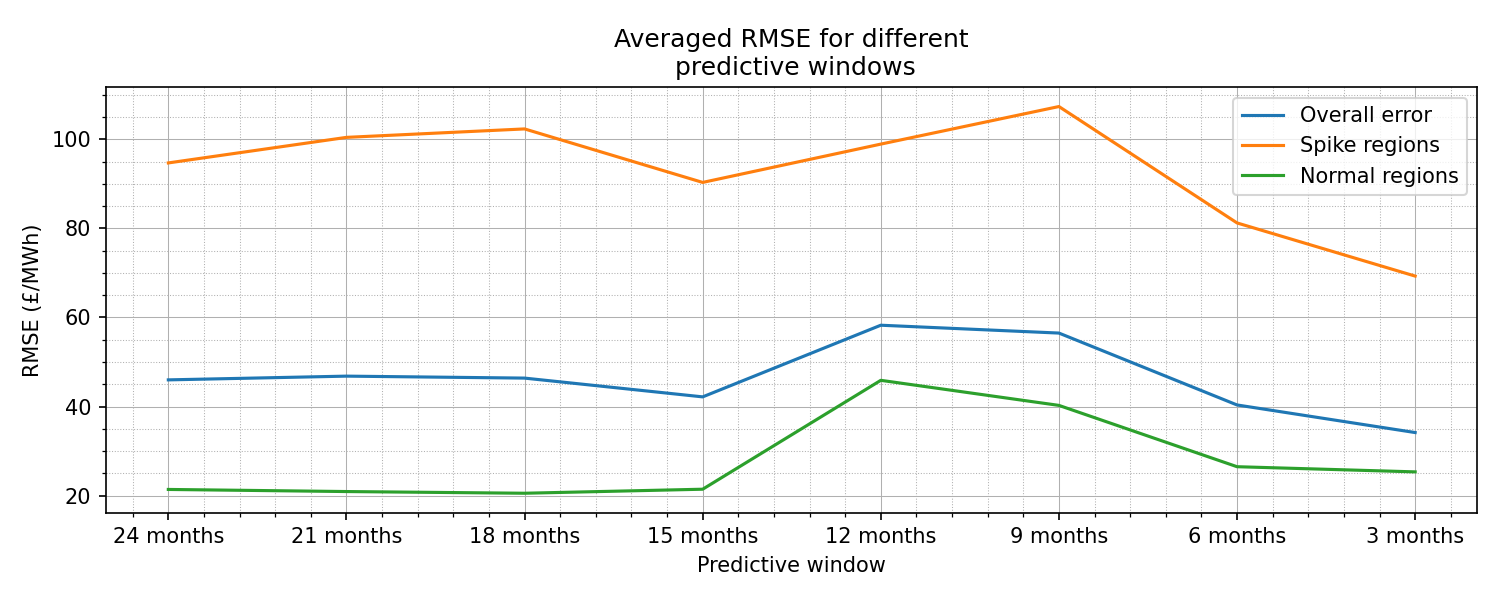

<IPython.core.display.Javascript object>


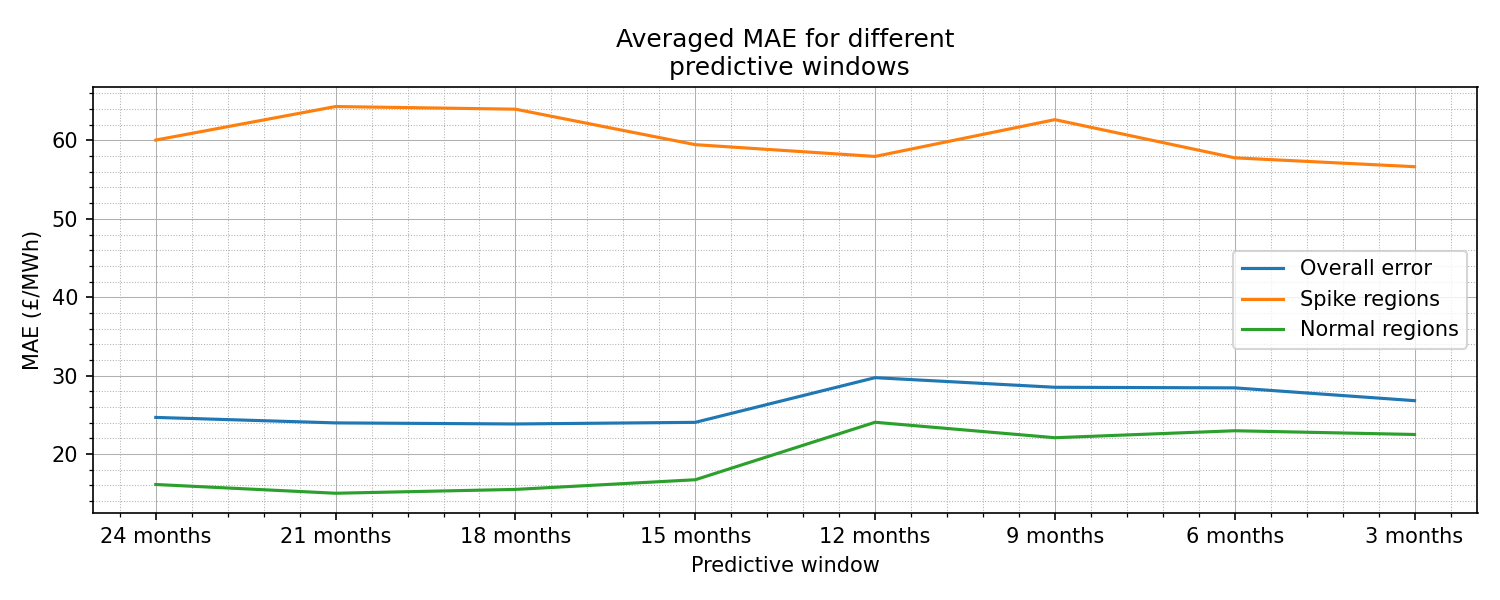

In [36]:
plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged RMSE for different\n predictive windows')
plt.plot(rmse_gen, label = 'Overall error')
plt.plot(rmse_spi, label = 'Spike regions')
plt.plot(rmse_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('RMSE (£/MWh)')
plt.xlabel('Predictive window')
plt.xticks([0,1,2,3,4,5,6,7], dates_labels)
plt.tight_layout()
plt.savefig('RMSE_predictive_window.png')

plt.figure(figsize=(10,4))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.title('Averaged MAE for different\n predictive windows')
plt.plot(mae_gen, label = 'Overall error')
plt.plot(mae_spi, label = 'Spike regions')
plt.plot(mae_nor, label = 'Normal regions')
plt.legend()
plt.ylabel('MAE (£/MWh)')
plt.xlabel('Predictive window')
plt.xticks([0,1,2,3,4,5,6,7], dates_labels)
plt.tight_layout()
plt.savefig('MAE_predictive_window.png')